In [1]:
import numpy as np
import random
from collections import defaultdict
import farmgame
import csv

In [2]:
# Configure the game
"""
def create_game():
    return farmgame.configure_game(layer="Items00", resourceCond="even", costCond="low", visibilityCond="full", redFirst=True)
"""
# Configure the game
def create_game(layer, resourceCond, costCond, visibilityCond, redFirst):
    return farmgame.configure_game(layer=layer, resourceCond=resourceCond, costCond=costCond, visibilityCond=visibilityCond, redFirst=redFirst)

In [3]:
# Initialize parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration rate
EPISODES = 1000  # Number of episodes

In [4]:
# Q-table: Nested dictionary for storing state-action values
Q_table = defaultdict(lambda: defaultdict(float))

In [5]:
def choose_action(state, legal_actions, player):
    if random.random() < EPSILON:
        # Explore: Random action
        return random.choice(legal_actions)
    else:
        # Exploit: Choose best action
        state_str = state_to_string(state, player)
        best_action = max(legal_actions, key=lambda action: Q_table[state_str][action.id], default=None)
        return best_action if best_action else random.choice(legal_actions)

In [6]:
# Convert state and player to a unique string representation
def state_to_string(state, player):
    return str(state) + "_" + player['name']

In [7]:
def flatten_state(state):
    """
    Flatten the state dictionary to extract useful information.
    """
    flattened_state = {}
    
    # Extract conditions
    flattened_state["costCond"] = state.costCond
    flattened_state["visibilityCond"] = state.visibilityCond
    flattened_state["resourceCond"] = state.resourceCond
    
    # Access playersDict as an attribute of the 'state' object
    for player_key, player_data in state.playersDict.items():
        #print(player_data)
        flattened_state[f"{player_key}_loc_x"] = player_data['loc']['x']
        flattened_state[f"{player_key}_loc_y"] = player_data['loc']['y']
        flattened_state[f"{player_key}_score"] = player_data['score']
        flattened_state[f"{player_key}_energy"] = player_data['energy']
        flattened_state[f"{player_key}_bonuspoints"] = player_data['bonuspoints']
        flattened_state[f"{player_key}BackpackSize"] = player_data['backpack']['capacity']
        flattened_state[f"{player_key}_has_helped"] = player_data['has_helped']
    
    """
    # Extract items (assuming Action objects have a 'name' attribute)
    flattened_state["items"] = [str(item) for item in state.items]  # Convert Action objects to string representations
    
    # Extract map information (for simplicity, just convert it to a string)
    flattened_state["map"] = str(state.map)
    """
    
    # Add other important state variables if needed
    flattened_state["turn"] = state.turn
    flattened_state["trial"] = state.trial
    
    return flattened_state

In [10]:
def log_state_to_csv(count, game_count, state, filename="episode_state_log_delete.csv"):
    """
    Log the state information to a CSV file.
    """
    # Flatten the state
    flattened_state = flatten_state(state)
    flattened_state['episode_num'] = count
    flattened_state['game_num'] = game_count
    flattened_state['objectLayer'] = vars(state)['objectLayer']
    
    # Define the headers for the CSV file (columns should correspond to the flattened state fields)
    headers = list(flattened_state.keys())
    
    # Write the state to CSV
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        
        # Write header only if the file is empty
        if file.tell() == 0:
            writer.writeheader()  # Write the header row
        
        writer.writerow(flattened_state)  # Write the state information as a new row
    print(f"State logged to {filename}")

In [20]:
def q_learning():
    rewards = []
    action_state_log = []  # To log states, actions, and Q-values
    count = 0 #episode count

    for episode in range(EPISODES):
        game_count = 0
        count += 1
        
        games = ['Items00', 'Items01', 'Items02', 'Items03', 'Items04', 'Items05', 'Items06', 'Items07', 'Items08', 'Items09', 'Items10', 'Items11']
        random.shuffle(games)
        
        resourceConds = ['even', 'uneven']
        resourceCond = random.choice(resourceConds)
        
        costConds = ['high', 'low']
        costCond = random.choice(costConds)
        
        visibilityConds =['full', 'self']
        visibilityCond = random.choice(visibilityConds)
        
        redFirsts = [True, False]
        
        episode_reward = 0
        
        for game in games:
            game_count += 1
            
            redFirst = random.choice(redFirsts)
            
            state = create_game(layer=game, resourceCond=resourceCond, costCond=costCond, visibilityCond=visibilityCond, redFirst=redFirst)
            done = False
            #episode_reward = 0

            #print('state', vars(state)['objectLayer'])

            while not done:
                current_player = state.players[state.turn]
                legal_actions = state.legal_actions()

                if not legal_actions:
                    action = None
                    next_state = state.take_action(action, inplace=True)

                    # Handle reward and done separately
                    reward = state.reward(current_player['name'])
                    done = state.is_done()  # Check game termination
                else:
                    # Choose action
                    action = choose_action(state, legal_actions, current_player)
                    action_id = action.id

                    '''if episode == 0:
                        print(vars(state))'''
                    # Log state and action
                    state_str = state_to_string(state, current_player)
                    action_state_log.append({
                        "state": state_str,
                        "action_id": action_id,
                        "action_name": action.name,
                        "q_value": Q_table[state_str][action_id] if state_str in Q_table else None
                    })

                    # Take action and observe next state and reward
                    next_state = state.take_action(action, inplace=True)

                    # Handle reward and done
                    result = state.reward(current_player['name'])
                    if isinstance(result, tuple):
                        reward, done = result
                    else:
                        reward = result
                        done = state.is_done()  # Fallback for game termination

                    episode_reward += reward

                    # Update Q-value
                    next_state_str = state_to_string(next_state, current_player)
                    future_rewards = [Q_table[next_state_str][a.id] for a in next_state.legal_actions()] if next_state.legal_actions() else [0]
                    max_future_reward = max(future_rewards, default=0)

                    Q_table[state_str][action_id] += ALPHA * (reward + GAMMA * max_future_reward - Q_table[state_str][action_id])

                    # Log the state at the end of each episode
                    log_state_to_csv(count, game_count, state)  # 'state' is the current state object for this episode

                    # Update state
                    state = next_state

            rewards.append(episode_reward)
            print(f"Episode {episode + 1}/{EPISODES} - Reward: {episode_reward}")
            
    return rewards, action_state_log

In [21]:
def save_action_log_to_csv(action_state_log, filename="action_state_log.csv"):
    # Define the headers
    headers = ["state", "action_id", "action_name", "q_value"]

    # Write to CSV file
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writeheader()  # Write header row
        writer.writerows(action_state_log)  # Write log rows
    print(f"Action state log saved to {filename}")

In [22]:
# Run Q-learning
reward_history, action_state_log = q_learning()

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 1/1000 - Reward: 126
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 8/1000 - Reward: 252
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 8/1000 - Reward: 2

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 17/1000 - Reward: 637
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 17/1000 - Reward: 837
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 25/1000 - Reward: 1301
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 25/1000 - Reward: 1501
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 34/1000 - Reward: 112
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 34/1000 - Reward: 136
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 43/1000 - Reward: 344
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 43/1000 - Reward:

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 49/1000 - Reward: 252
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 58/1000 - Reward: 926
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 58/1000 - Reward: 1246
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 66/1000 - Reward: 60
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 72/1000 - Reward: 1287
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 72/1000 - Reward: 1572
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 80/1000 - Reward: 28
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 88/1000 - Reward: 672
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 88/1000 - Reward:

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 96/1000 - Reward: 186
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
Episode 103/1000 - Reward: 112
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 103/1000 - Reward: 112
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 111/1000 - Reward: 602
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 119/1000 - Reward: 606
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 126/1000 - Reward: 1101
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
Episode 134/1000 - Reward: 382
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 134/1000 - Reward: 632
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
Episode 140/1000 - Reward: 288
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 140/1000 - Reward: 288
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 148/1000 - Reward: 60
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 148/1000 - Reward: 180
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 156/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 163/1000 - Reward: 247
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 171/1000 - Reward: 232
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 179/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 186/1000 - Reward: 200
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
Episode 194/1000 - Reward: 72
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 194/1000 - Reward: 104
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 201/1000 - Reward: 16
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 201/1000 - Reward: 136
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 210/1000 - Reward: 195
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 218/1000 - Reward: 136
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 226/1000 - Reward: 323
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 226/1000 - Reward: 395
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 234/1000 - Reward: 68
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 234/1000 - Reward: 188
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 242/1000 - Reward: 1568
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 250/1000 - Reward: 294
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 250/1000 - Rewar

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 258/1000 - Reward: 184
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 266/1000 - Reward: 1306
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 266/1000 - Reward: 1486
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 275/1000 - Reward: 450
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 275/1000 - Reward: 650
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 282/1000 - Reward: 1489
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 290/1000 - Reward: 881
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 290/1000 - Reward: 1089
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_del

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 297/1000 - Reward: 100
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 298/1000 - Reward: 270
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 306/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 306/1000 - Reward: 75
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 314/1000 - Reward: 1195
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 314/1000 - Reward: 1315
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 323/1000 - Reward: 84
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 323/1000 - Reward: 84
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 330/1000 - Reward: 172
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 330/1000 - Reward: 188
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 339/1000 - Reward: 284
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 339/1000 - Reward: 484
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 347/1000 - Reward: 1364
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 347/1000 - Reward: 1572
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 356/1000 - Reward: 180
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 364/1000 - Reward: 156
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 364/1000 - Reward: 276
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 373/1000 - Reward: 16
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 373/1000 - Reward

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 379/1000 - Reward: 1516
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 387/1000 - Reward: 1394
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 387/1000 - Reward: 1582
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 395/1000 - Reward: 240
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 395/1000 - Reward: 256
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 403/1000 - Reward: 60
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 403/1000 - Reward: 60
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 412/1000 - Reward: 526
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
Episode 420/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 420/1000 - Reward: 60
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 428/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 437/1000 - Reward: 466
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 445/1000 - Reward: 1223
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 453/1000 - Reward: 1180
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 453/1000 - Reward: 1332
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 461/1000 - Reward: 169
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 470/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 478/1000 - Reward: 1073
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 486/1000 - Reward: 661
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 486/1000 - Reward: 781
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 494/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 502/1000 - Reward: 790
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 502/1000 - Rewar

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 511/1000 - Reward: 410
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 511/1000 - Reward: 614
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 519/1000 - Reward: 327
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 519/1000 - Reward: 527
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 527/1000 - Reward: 880
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 527/1000 - Reward: 1060
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_del

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 535/1000 - Reward: 1256
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 543/1000 - Reward: 1927
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 551/1000 - Reward: 1564
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 560/1000 - Reward: 92
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 568/1000 - Reward: 1198
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 568/1000 - Reward: 1454
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 577/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 577/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.c

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 585/1000 - Reward: 552
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 585/1000 - Reward: 812
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 594/1000 - Reward: 12
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 603/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
Episode 610/1000 - Reward: 1962
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 611/1000 - Reward: 140
State logged to episode_state_log_delete.csv
State logged to episode_state_log_del

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 619/1000 - Reward: 328
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 626/1000 - Reward: 1152
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 626/1000 - Reward: 1266
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 634/1000 - Reward: 630
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 634/1000 - Reward: 838
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 642/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 650/1000 - Reward: 405
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 657/1000 - Reward: 1316
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 657/1000 - Reward: 1436
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 666/1000 - Reward: 250
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 674/1000 - Reward: 224
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 682/1000 - Reward: 76
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 682/1000 - Reward: 92
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 691/1000 - Reward: 1449
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 699/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 699/1000 - Reward: 80
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 706/1000 - Reward: 159
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 715/1000 - Reward: 75
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 715/1000 - Reward

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 723/1000 - Reward: 690
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 730/1000 - Reward: 100
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 730/1000 - Rewar

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 738/1000 - Reward: 891
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 738/1000 - Reward: 1077
State logged to episode_state_log_delete.csv
State logged to episode_state_log_del

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 746/1000 - Reward: 518
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 754/1000 - Reward: 40
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 754/1000 - Reward: 40
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 761/1000 - Reward: 1997
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 762/1000 - Reward: 60
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 768/1000 - Reward: 272
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logg

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 784/1000 - Reward: 504
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 791/1000 - Reward: 1187
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 791/1000 - Reward: 1403
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 798/1000 - Reward: 175
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 798/1000 - Reward: 195
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 805/1000 - Reward: 256
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 813/1000 - Reward: 112
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 820/1000 - Reward: 291
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 828/1000 - Reward: 96
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 837/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logg

State logged to episode_state_log_delete.csv
Episode 853/1000 - Reward: 368
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 854/1000 - Reward: 128
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 861/1000 - Reward: 1714
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
Episode 869/1000 - Reward: 88
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 869/1000 - Reward: 88
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 876/1000 - Reward: 229
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 884/1000 - Reward: 200
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 891/1000 - Reward: 140
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 900/1000 - Reward: 32
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_s

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 908/1000 - Reward: 172
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 917/1000 - Reward: 176
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 917/1000 - Rewar

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 925/1000 - Reward: 0
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_st

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 933/1000 - Reward: 24
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 933/1000 - Reward

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 941/1000 - Reward: 136
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 941/1000 - Reward: 136
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_dele

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 949/1000 - Reward: 1999
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 957/1000 - Reward: 1311
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 957/1000 - Reward: 1511
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_de

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 965/1000 - Reward: 897
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 973/1000 - Reward: 858
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 980/1000 - Reward: 40
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 981/1000 - Reward: 248
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delet

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 988/1000 - Reward: 1803
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode

State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
Episode 996/1000 - Reward: 376
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_state_log_delete.csv
State logged to episode_

TypeError: unhashable type: 'slice'

In [37]:
# Save the action state log to a CSV file
save_action_log_to_csv(action_state_log, filename="action_state_log5.csv")

Action state log saved to action_state_log5.csv


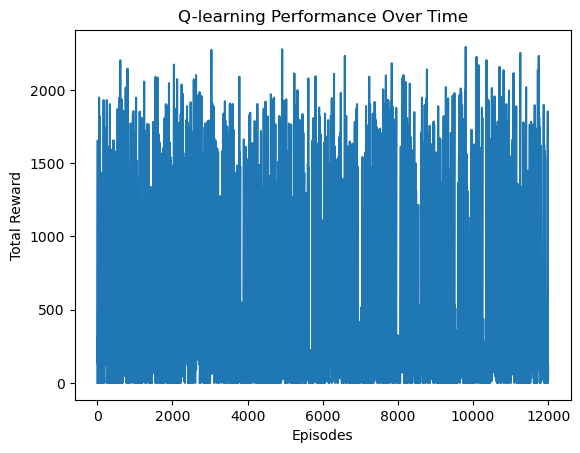

In [71]:
# Plot reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q-learning Performance Over Time')
plt.show()